In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

In [53]:
# 폰트지정
plt.rcParams['font.family'] = 'Malgun Gothic'

# 마이너스 부호 깨짐 지정
plt.rcParams['axes.unicode_minus'] = False

# 숫자가 지수표현식으로 나올 때 지정
pd.options.display.float_format = '{:.2f}'.format

In [54]:
# 데이터 로드 및 전처리
file_path = "./dataset/seoul_pm10.csv"
data = pd.read_csv(file_path, encoding='cp949')

In [55]:
# 강남구 데이터만 필터링
gangnam_data = data[data['area'] == '강남구'].copy()

In [56]:
# date를 인덱스로 설정
gangnam_data['date'] = pd.to_datetime(gangnam_data['date'])
gangnam_data.set_index('date', inplace=True)

In [57]:
# pm10 데이터만 선택
dust_data = gangnam_data['pm10'].values

In [58]:
# 결측치 확인 및 처리
if np.isnan(dust_data).any():
    # 결측치를 이전 값으로 채우기
    dust_data = pd.Series(dust_data).fillna(method='ffill').values

C:\Users\ahnda\AppData\Local\Temp\ipykernel_7632\2837055220.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dust_data = pd.Series(dust_data).fillna(method='ffill').values


In [59]:
# 데이터 정규화
scaler = MinMaxScaler(feature_range=(0, 1))
dust_data_scaled = scaler.fit_transform(dust_data.reshape(-1, 1))

In [60]:
# 데이터셋 생성 함수
def create_dataset(dataset, look_back=24):  # 24시간을 기준으로 예측
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(y)

In [61]:
# 데이터셋 생성
look_back = 24
X, y = create_dataset(dust_data_scaled, look_back)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [62]:
# 데이터 분리
train_size = int(len(X) * 0.8)
X_train = X[:train_size]
X_test = X[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]

In [63]:
# RNN 모델 구성
model = Sequential([
    SimpleRNN(50, input_shape=(look_back, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

c:\99.참고자료\04.교육\소스코드\mlPrjoct\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [64]:
# 모델 학습
history = model.fit(X_train, y_train, 
                   epochs=5,  # epoch 수 증가
                   batch_size=32, 
                   validation_data=(X_test, y_test),
                   verbose=1)

Epoch 1/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0025 - val_loss: 5.8695e-04
Epoch 2/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.5798e-04 - val_loss: 4.0972e-04
Epoch 3/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.6173e-04 - val_loss: 4.0226e-04
Epoch 4/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.7684e-04 - val_loss: 3.3224e-04
Epoch 5/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.5606e-04 - val_loss: 3.2930e-04


In [65]:
# 예측
predictions = model.predict(X_test)

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [66]:
# 예측값과 실제값 복원
y_test_plot = scaler.inverse_transform(y_test.reshape(-1, 1))
predictions_plot = scaler.inverse_transform(predictions)

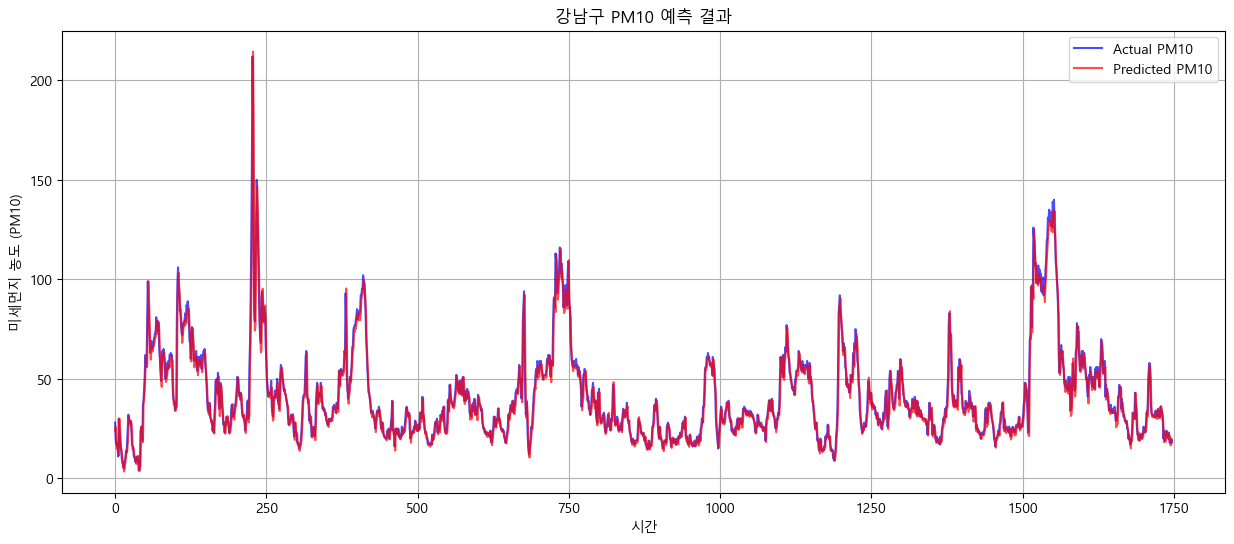

In [67]:
# 결과 시각화
plt.figure(figsize=(15, 6))
plt.plot(y_test_plot, label='Actual PM10', color='blue', alpha=0.7)
plt.plot(predictions_plot, label='Predicted PM10', color='red', alpha=0.7)
plt.title('강남구 PM10 예측 결과')
plt.xlabel('시간')
plt.ylabel('미세먼지 농도 (PM10)')
plt.legend()
plt.grid(True)
plt.show()

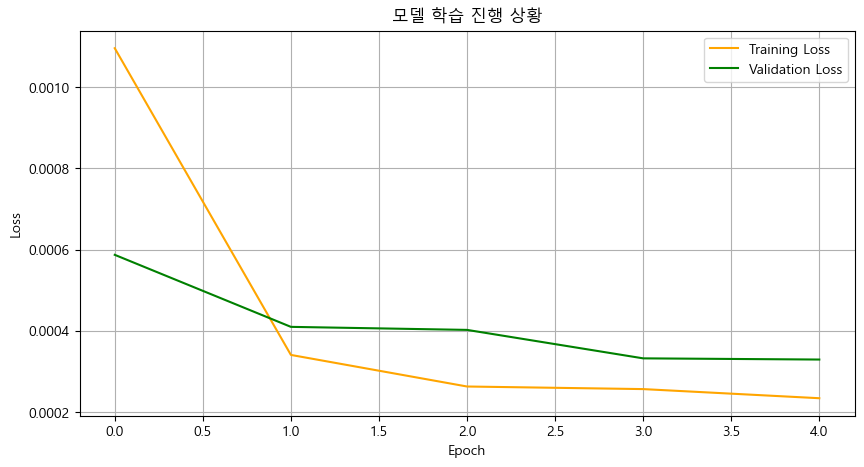

In [68]:
# 학습 손실 시각화
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='orange')
plt.plot(history.history['val_loss'], label='Validation Loss', color='green')
plt.title('모델 학습 진행 상황')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()